#### Importing relevant libraries

In [625]:
# load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report as clf_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline



# load the dataset
train_data_cleaned = pd.read_csv('Data/train_data_clean.csv')   
train_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59026 entries, 0 to 59025
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59026 non-null  float64
 1   funder                 59026 non-null  object 
 2   gps_height             59026 non-null  int64  
 3   installer              59026 non-null  object 
 4   basin                  59026 non-null  object 
 5   region_code            59026 non-null  int64  
 6   district_code          59026 non-null  int64  
 7   population             59026 non-null  int64  
 8   public_meeting         59026 non-null  object 
 9   scheme_management      59026 non-null  object 
 10  permit                 59026 non-null  bool   
 11  extraction_type_class  59026 non-null  object 
 12  management             59026 non-null  object 
 13  payment                59026 non-null  object 
 14  water_quality          59026 non-null  object 
 15  qu

Defining a clas for modeling

In [626]:
# Define my class
class Modelbuilder:
    def __init__(self, model):
        self.model = model

    def preprocessing(self, X_train, X_test):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)    

    def predict_train(self, X_train):
        y_train_pred = self.model.predict(X_train)
        return y_train_pred
    
    def predict_test(self, X_test):
        y_test_pred = self.model.predict(X_test)
        return y_test_pred
    
    def evaluate(self, y_train, y_train_pred, y_test, y_test_pred):
        accuracy_train = accuracy_score(y_train, y_train_pred)
        
        accuracy_test = accuracy_score(y_test, y_test_pred)
        f1_test = f1_score(y_test, y_test_pred, average='weighted')
        class_report_test = clf_report(y_test, y_test_pred)
        matrix_test = confusion_matrix(y_test, y_test_pred)
        
        evaluation_results = {
            'train': {
                'accuracy': accuracy_train
            },
            'test': {
                'accuracy': accuracy_test,
                'f1_score': f1_test,
                'classification_report': class_report_test,
                'confusion_matrix': matrix_test
            }
        }
        return evaluation_results

### Data Cleaning continuation

In [627]:
# top ten funders in the dataset
train_data_cleaned['funder'].value_counts().head(11)

Government Of Tanzania    9014
Unknown                   4418
Danida                    3114
Hesawa                    2200
Rwssp                     1374
Kkkt                      1286
World Vision              1246
World Bank                1244
Unicef                    1057
Tasaf                      876
District Council           843
Name: funder, dtype: int64

* Create multiple subsets of the train_df DataFrame based on the values in the 'funder' column.
* Each subset focused on a specific funder then stored it in a separate DataFrame.
* Combine these subsets into a single DataFrame named df_funder using the pd.concat() function.

In [628]:
# to combine all subsets into a single dataframe using pd.concat() function
df1 = train_data_cleaned.loc[train_data_cleaned['funder'] == 'Government Of Tanzania']
df2 = train_data_cleaned.loc[train_data_cleaned['funder'] == 'Danida']
df3 = train_data_cleaned.loc[train_data_cleaned['funder'] == 'Hesawa']
df4 = train_data_cleaned.loc[train_data_cleaned['funder'] == 'Rwssp']
df5 = train_data_cleaned.loc[train_data_cleaned['funder'] == 'World Bank']
df6 = train_data_cleaned.loc[train_data_cleaned['funder'] == 'Kkkt']
df7 = train_data_cleaned.loc[train_data_cleaned['funder'] == 'World Vision']
df8 = train_data_cleaned.loc[train_data_cleaned['funder'] == 'Unicef']
df9 = train_data_cleaned.loc[train_data_cleaned['funder'] == 'Tasaf']
df10 = train_data_cleaned.loc[train_data_cleaned['funder'] == 'District Council']
df_funder = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10], ignore_index=True)
# new DataFrame contains all the rows from the original DataFrame 
# the 'funder' column matches the specified funders.

In [629]:
# To group values together

train_data_cleaned['funder_cat'] = train_data_cleaned['funder'] #creating new column

c_fund = ['Danida','Government Of Tanzania','Hesawa','Rwssp','World Bank','Kkkt', 'World Vision',
         'Unicef','Tasaf','District Council']

train_data_cleaned.loc[~train_data_cleaned["funder_cat"].isin(c_fund), "funder_cat"] = "Others"

# to obtain the no of unique values
train_data_cleaned['funder_cat'].nunique()
# This count represents the number of distinct funders after the grouping operation. 
# Each unique value corresponds to a specific funder category, including the individual funders explicitly mentioned and the "Others" category.
# We have 11 unique values for this column

# Now that I have categorized funder column, we can proceed to drop it
train_data_cleaned.drop(columns=['funder'],inplace=True )

Next to look at is the Installer column. I noticed some spelling mistakes in the column, i willl correct them.

In [630]:
train_data_cleaned['installer'].replace(to_replace=('District Water Department', 'District water depar', 'Distric Water Department'),
                                        value='District water department', inplace=True)

train_data_cleaned['installer'].replace(to_replace=('FinW', 'Fini water', 'FINI WATER'), value='Fini Water', inplace=True)
train_data_cleaned['installer'].replace(to_replace='JAICA', value='Jaica', inplace=True)

train_data_cleaned['installer'].replace(to_replace=('COUN', 'District COUNCIL', 'DISTRICT COUNCIL', 'District Counci',
                                                    'District Council', 'Council', 'Counc', 'District  Council', 'Distri'),
                                        value='District council', inplace=True)

train_data_cleaned['installer'].replace(to_replace=('RC CHURCH', 'RC Churc', 'RC', 'RC Ch', 'RC C', 'RC CH', 'RC church',
                                                    'RC CATHORIC'), value='RC Church', inplace=True)

train_data_cleaned['installer'].replace(to_replace=('Central Government', 'Tanzania Government', 'central government',
                                                    'Cental Government', 'Cebtral Government', 'Tanzanian Government',
                                                    'Tanzania government', 'Centra Government', 'CENTRAL GOVERNMENT',
                                                    'TANZANIAN GOVERNMENT', 'Central govt', 'Centr', 'Centra govt'),
                                        value='Central government', inplace=True)

train_data_cleaned['installer'].replace(to_replace=('World vision', 'World Division', 'World Vision'), value='world vision',
                                        inplace=True)

train_data_cleaned['installer'].replace(to_replace=('Unisef', 'UNICEF'), value='Unicef', inplace=True)
train_data_cleaned['installer'].replace(to_replace='DANID', value='DANIDA', inplace=True)

train_data_cleaned['installer'].replace(to_replace=('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi',
                                                    'Village Council', 'Village Counil', 'Villages', 'Vill', 'Village community',
                                                    'Villaers', 'Village Community', 'Villag', 'Villege Council', 'Village council',
                                                    'Village  Council', 'Villagerd', 'Villager', 'Village Technician',
                                                    'Village Office', 'Village community members'),
                                        value='villagers', inplace=True)

train_data_cleaned['installer'].replace(to_replace=('Commu', 'Communit', 'commu', 'COMMU', 'COMMUNITY'), value='Community',
                                        inplace=True)

train_data_cleaned['installer'].replace(to_replace=('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM', 'GOVERN', 'Gover', 'Gove',
                                                    'Governme', 'Governmen'), value='Government', inplace=True)

train_data_cleaned['installer'].replace(to_replace='Hesawa', value='HESAWA', inplace=True)

# continue to replacing spelling mistakes and getting together values
train_data_cleaned['installer'].replace(to_replace='Colonial Government', value='Colonial government', inplace=True)
train_data_cleaned['installer'].replace(to_replace='Government of Misri', value='Misri Government', inplace=True)
train_data_cleaned['installer'].replace(to_replace='Italy government', value='Italian government', inplace=True)
train_data_cleaned['installer'].replace(to_replace='British colonial government', value='British government', inplace=True)
train_data_cleaned['installer'].replace(to_replace='Concern /government', value='Concern/Government', inplace=True)
train_data_cleaned['installer'].replace(to_replace='Village Government', value='Village government', inplace=True)
train_data_cleaned['installer'].replace(to_replace='Government and Community', value='Government /Community', inplace=True)
train_data_cleaned['installer'].replace(to_replace='Cetral government /RC', value='RC church/Central Gover', inplace=True)
train_data_cleaned['installer'].replace(to_replace=('Government /TCRS', 'Government/TCRS'), value='TCRS /Government', inplace=True)
train_data_cleaned['installer'].replace(to_replace='ADRA /Government', value='ADRA/Government', inplace=True)

train_data_cleaned['installer'].value_counts().head(11)

DWE                   17361
Unknown                4435
Government             2629
DANIDA                 1602
Community              1507
HESAWA                 1379
RWE                    1205
District council       1179
Central government     1114
KKKT                    898
TCRS                    707
Name: installer, dtype: int64

In [631]:
# Grouping by installer
df_1 = train_data_cleaned.loc[train_data_cleaned['installer']== 'DWE']
df_2 = train_data_cleaned.loc[train_data_cleaned['installer']== 'Government']              
df_3 = train_data_cleaned.loc[train_data_cleaned['installer']== 'Community'] 
df_4 = train_data_cleaned.loc[train_data_cleaned['installer']== 'DANIDA'] 
df_5 = train_data_cleaned.loc[train_data_cleaned['installer']== 'RWE'] 
df_6 = train_data_cleaned.loc[train_data_cleaned['installer']== 'District council'] 
df_7 = train_data_cleaned.loc[train_data_cleaned['installer']== 'Central government'] 
df_8 = train_data_cleaned.loc[train_data_cleaned['installer']== 'KKKT']
df_9 = train_data_cleaned.loc[train_data_cleaned['installer']== 'HESAWA'] 
df_10 = train_data_cleaned.loc[train_data_cleaned['installer']== 'TCRS'] 
df_installer = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10], ignore_index=True)

In [632]:
installer_counts = train_data_cleaned['installer'].value_counts()
others = installer_counts[installer_counts < 400].index.tolist()
train_data_cleaned['installer'].replace(to_replace=others, value='Other', inplace=True)

# To make new categorizes, creating new column
train_data_cleaned['installer_cat'] = train_data_cleaned['installer']
# to convert the values which have less than 400 value counts to "others"
c_ins = ['DWE','Government','Community','DANIDA','RWE','District council', 'Central government',
         'KKKT','HESAWA','TCRS']

train_data_cleaned.loc[~train_data_cleaned["installer_cat"].isin(c_ins), "installer_cat"] = "Others"
# Now that we have categorized installer column, we can proceed to drop it
train_data_cleaned.drop(columns=['installer'],inplace=True )

### Exploratory Data Analysis

We will check the distribution of the status_group column(our dependent variable)

functional                 32054
non functional             22656
functional needs repair     4316
Name: status_group, dtype: int64


Text(0, 0.5, 'Count')

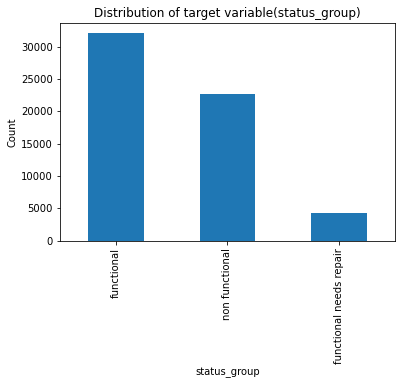

In [633]:
# check distribution of target variable(status_group)
print(train_data_cleaned['status_group'].value_counts()) 
#display using bar graph
train_data_cleaned['status_group'].value_counts().plot.bar()
# set title for the graph
plt.title('Distribution of target variable(status_group)')
# set x and y labels
plt.xlabel('status_group')
plt.ylabel('Count')

Next step, visualizing the distribution of funders in dataframe. We have so many unique funders in the dataset, I will consider the top ten funders.

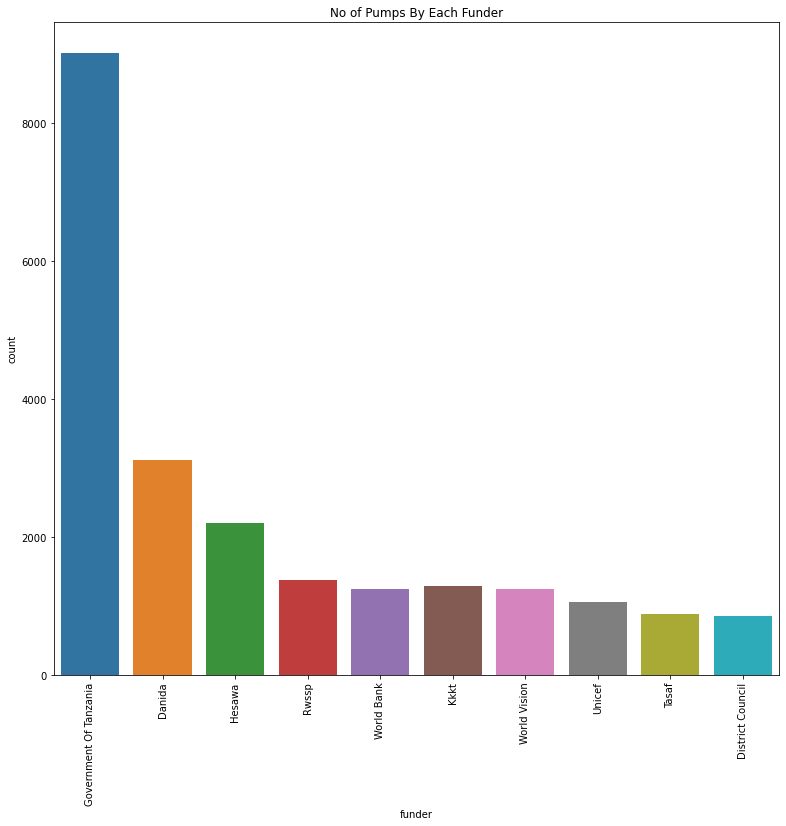

In [635]:
plt.figure(figsize=(13,12))
ax = sns.countplot(x='funder', data=df_funder)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('No of Pumps By Each Funder')
plt.show()

* Modify our bar plot to show the number of pumps associated with each funder
* categorized by the working conditions (status group) of the pumps.

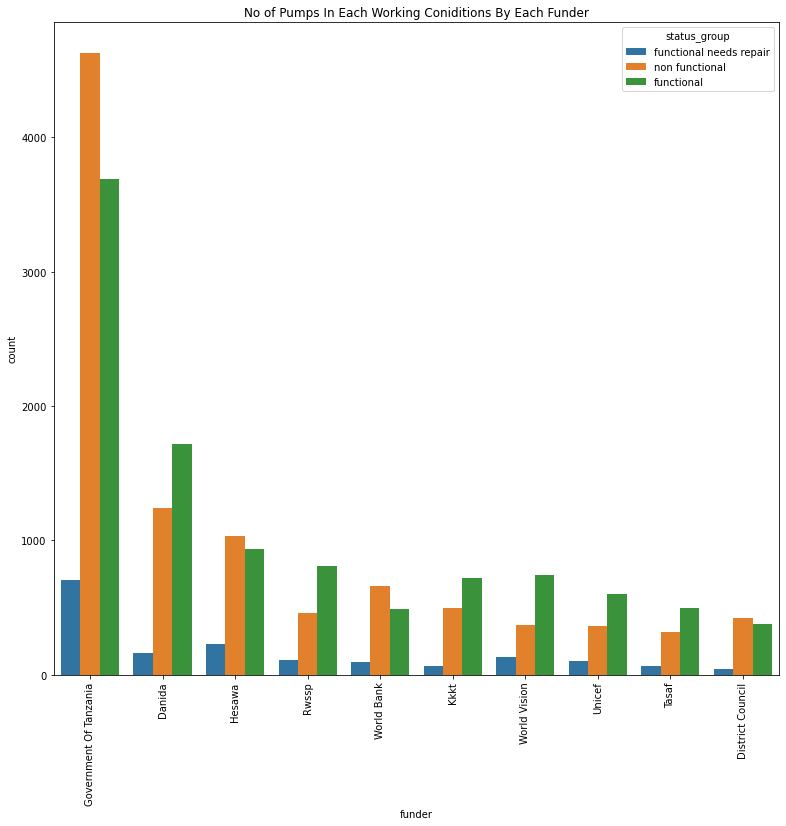

In [636]:
plt.figure(figsize=(13,12))
ax = sns.countplot(x='funder', hue="status_group", data=df_funder)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('No of Pumps In Each Working Coniditions By Each Funder')
plt.show()

Most of the water points which are funded by government are non-functional.

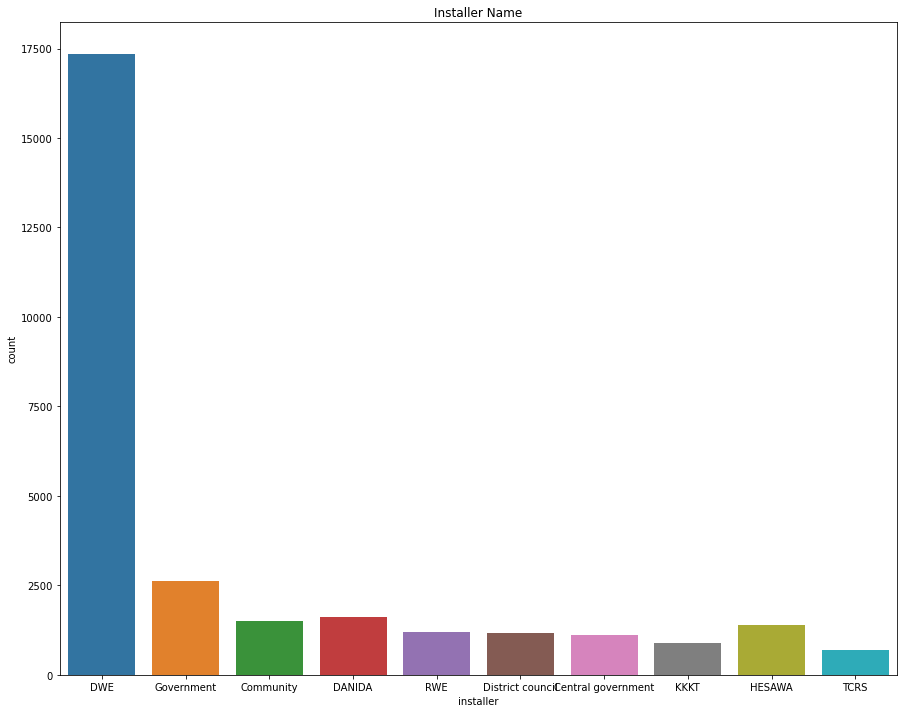

In [ ]:
plt.figure(figsize=(15,12))
ax = sns.countplot(x='installer',data=df_installer)
plt.title('Installer Name')
plt.show()

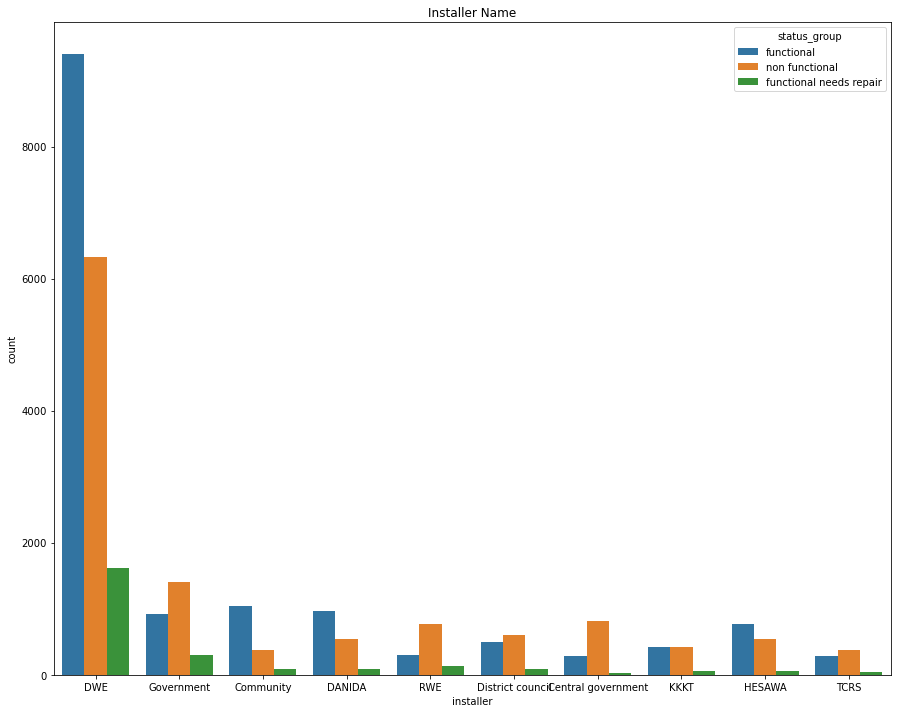

In [ ]:
plt.figure(figsize=(15,12))
ax = sns.countplot(x='installer', hue="status_group", data=df_installer)
plt.title('Installer Name')
plt.show()

* Most functional water wells were installed by DWE. 
* Majority of water points which central government,district council, RWE, TCRS installed are non-functional.

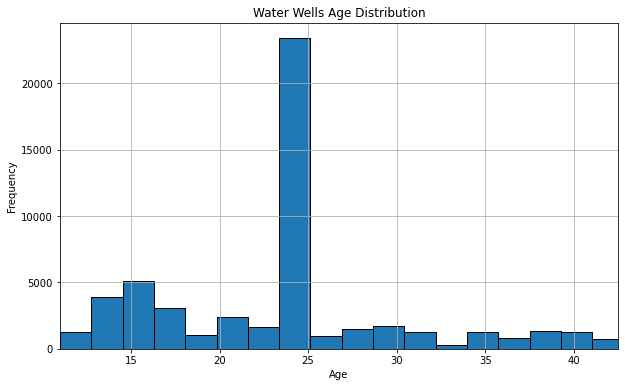

In [637]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(train_data_cleaned['age'], bins=30,edgecolor='black')
plt.title('Water Wells Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xlim(11, 42.5)  # Set x-axis limits to match the specified age range
plt.grid(True)
plt.show()


* Most wells have between 23 and 26 years.

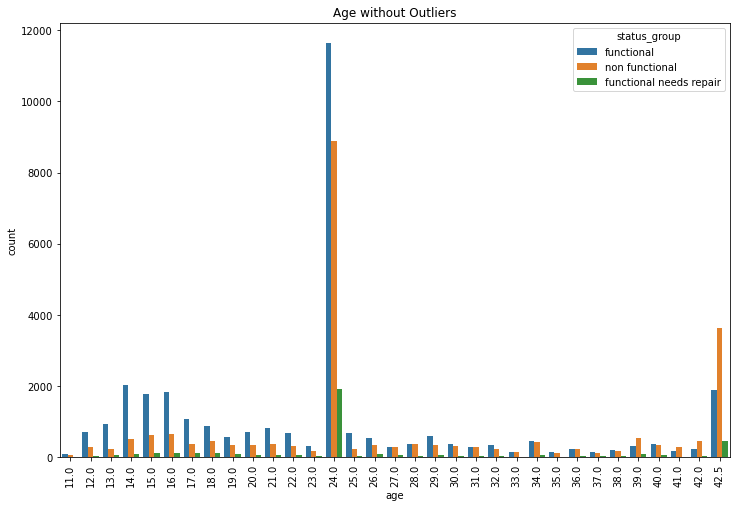

In [ ]:
def detect_and_handle_outliers(df, method='remove'):
    # Select all numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numerical_cols:
        # 1st quartile
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile
        Q3 = np.percentile(df[col], 75)
        
        # IQR
        IQR = Q3 - Q1
        
        # Outlier step
        outlier_step = IQR * 1.5
        
        # Determine the indices of outliers
        outliers = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        if method == 'remove':
            # Remove outliers
            df = df.drop(outliers)
        elif method == 'cap':
            # Cap outliers
            lower_cap = Q1 - outlier_step
            upper_cap = Q3 + outlier_step
            df[col] = np.where(df[col] < lower_cap, lower_cap, df[col])
            df[col] = np.where(df[col] > upper_cap, upper_cap, df[col])

    return df

train_data_c = detect_and_handle_outliers(train_data_cleaned, method='cap')

# Visualize age without outliers
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='age', hue="status_group", data=train_data_c)
plt.title('Age without Outliers')

# Rotate x-labels vertically
plt.xticks(rotation=90)

plt.show()

Most functional and non-functinal wells are aged 24 years.



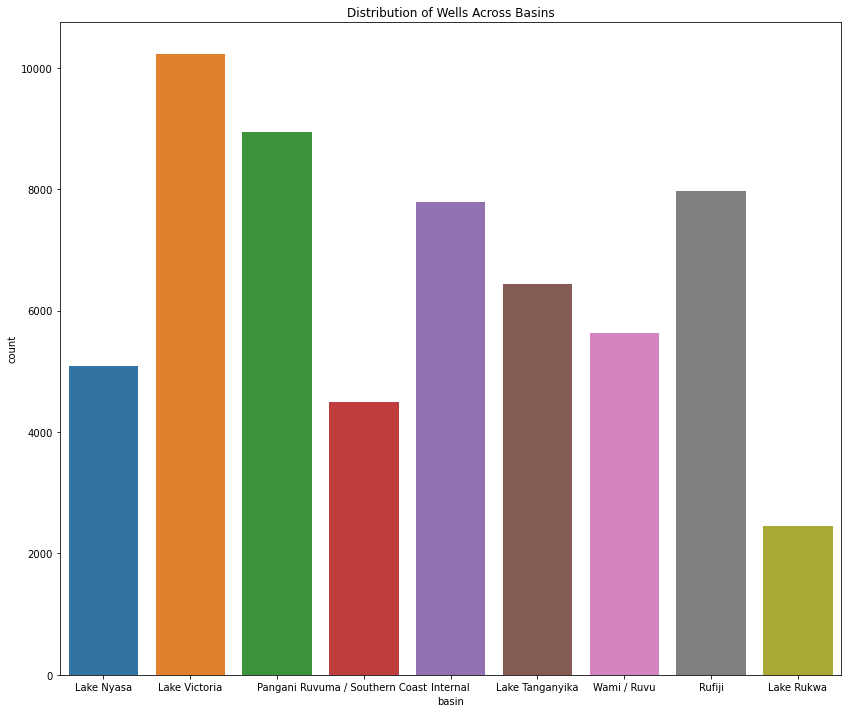

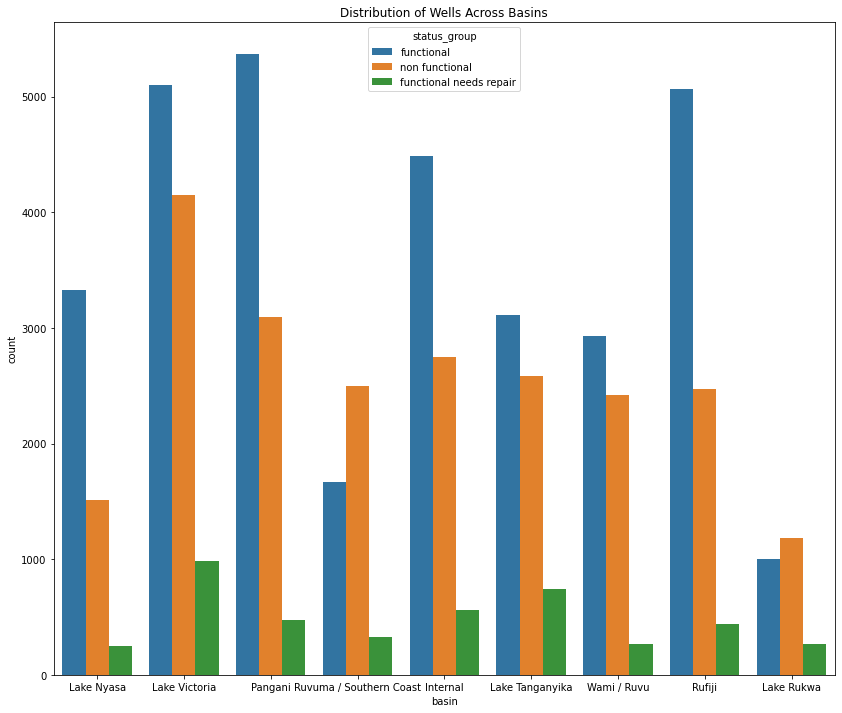

In [ ]:
plt.figure(figsize=(14,12))
ax = sns.countplot(x='basin', data=train_data_cleaned)
plt.title('Distribution of Wells Across Basins')
plt.show()

plt.figure(figsize=(14,12))
ax = sns.countplot(x='basin', hue="status_group", data=train_data_cleaned)
plt.title('Distribution of Wells Across Basins')
plt.show()

There is a correlation between the basin and the functionality of a well.

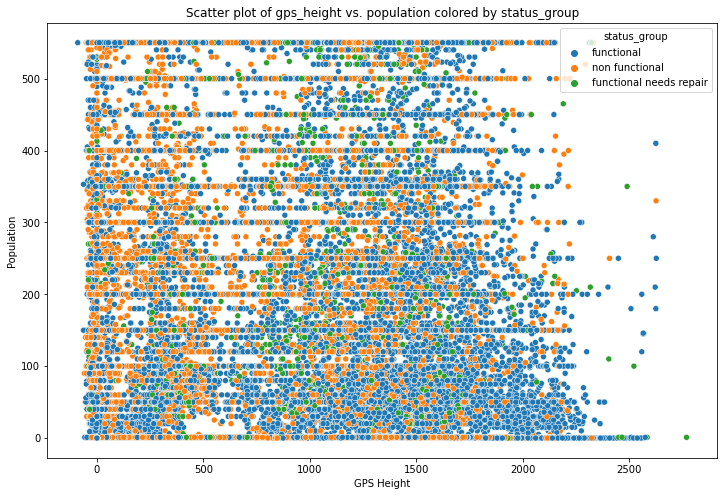

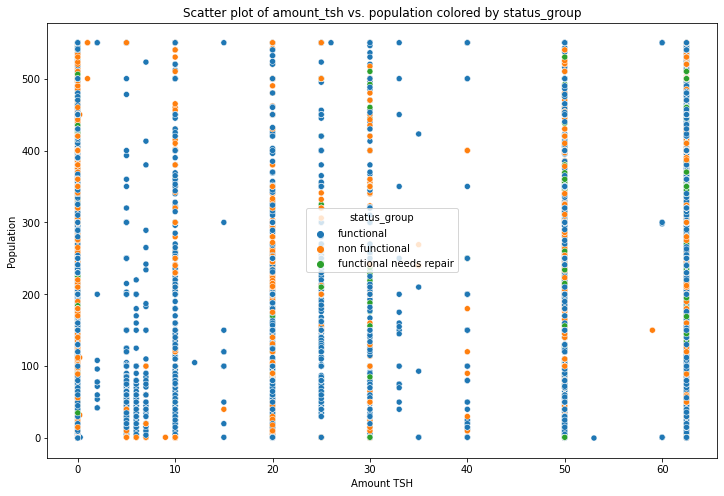

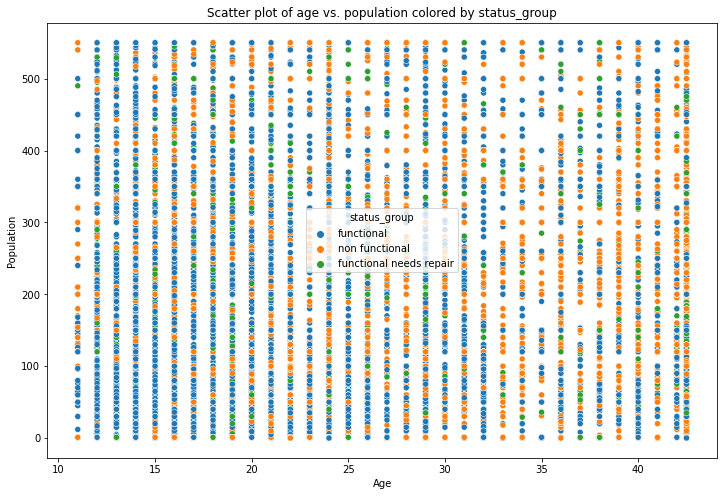

In [ ]:
# Example scatter plot: gps_height vs. population with status_group as hue
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train_data_cleaned, x='gps_height', y='population', hue='status_group')
plt.title('Scatter plot of gps_height vs. population colored by status_group')
plt.xlabel('GPS Height')
plt.ylabel('Population')
plt.show()

# Example scatter plot: amount_tsh vs. population with status_group as hue
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train_data_cleaned, x='amount_tsh', y='population', hue='status_group')
plt.title('Scatter plot of amount_tsh vs. population colored by status_group')
plt.xlabel('Amount TSH')
plt.ylabel('Population')
plt.show()

# Example scatter plot: age vs. population with status_group as hue
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train_data_cleaned, x='age', y='population', hue='status_group')
plt.title('Scatter plot of age vs. population colored by status_group')
plt.xlabel('Age')
plt.ylabel('Population')
plt.show()


The visualizations above are hard to interpret. I will try visualizing using box plots.

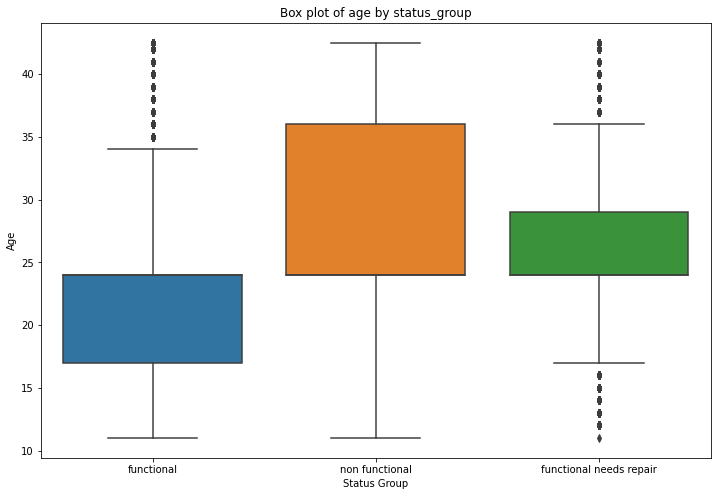

In [ ]:
# box plot: age
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_data_cleaned, x='status_group', y='age')
plt.title('Box plot of age by status_group')
plt.xlabel('Status Group')
plt.ylabel('Age')
plt.show()


From the above visualization, most functional water wells are 24 years and below. Most non-functional wells are over 24 years.

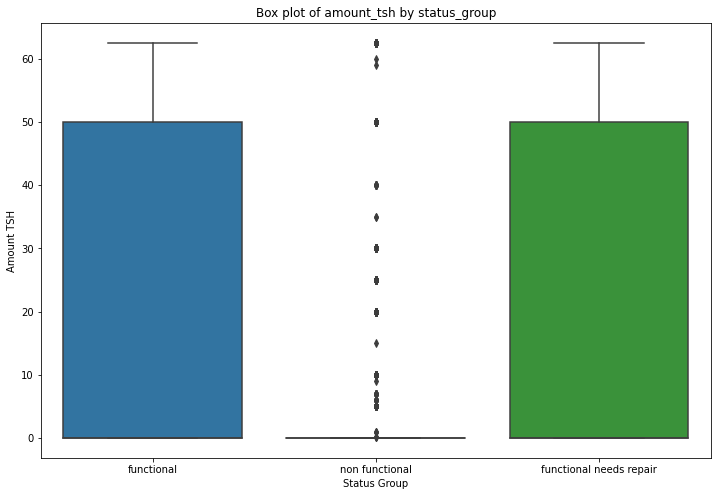

In [ ]:
# box plot: amount_tsh
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_data_cleaned, x='status_group', y='amount_tsh')
plt.title('Box plot of amount_tsh by status_group')
plt.xlabel('Status Group')
plt.ylabel('Amount TSH')
plt.show()


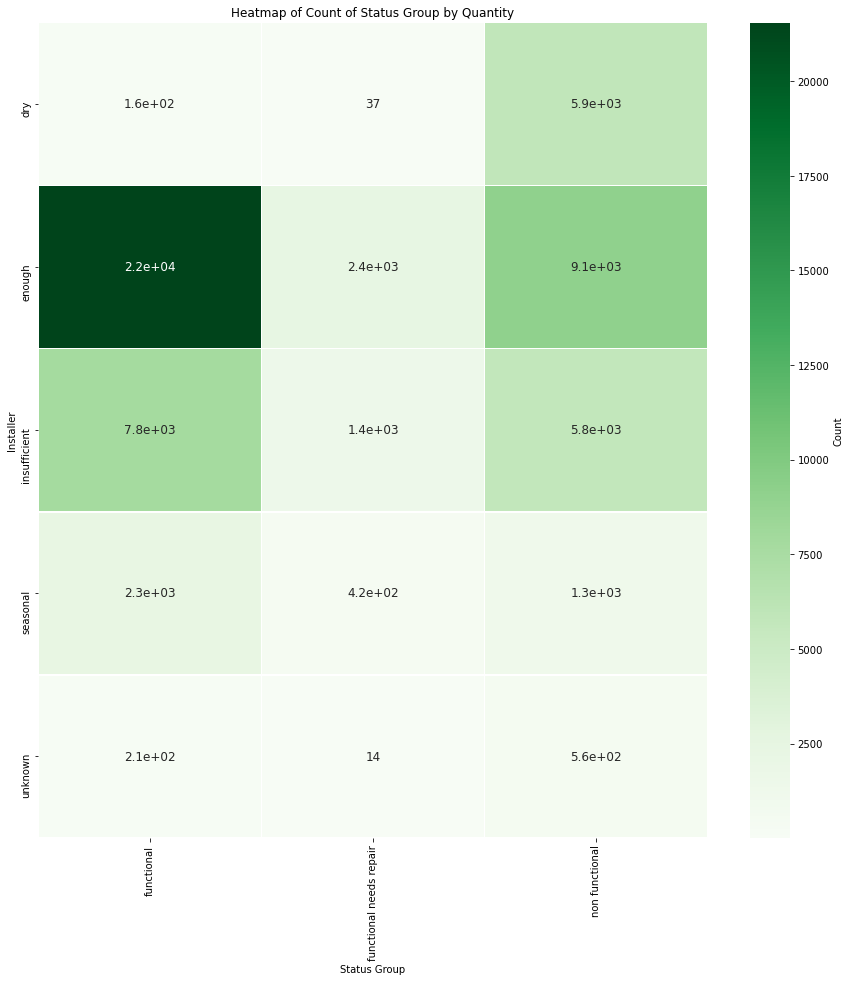

In [ ]:
# Create a pivot table with counts of status_group for each installer
pivot_table_installer = train_data_cleaned.groupby(['quantity', 'status_group']).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(pivot_table_installer, annot=True,annot_kws={"size": 12}, cmap='Greens', linewidths=0.5, cbar_kws={'label': 'Count'})
plt.title('Heatmap of Count of Status Group by Quantity')
plt.xlabel('Status Group')
plt.ylabel('Installer')
plt.xticks(rotation=90)
plt.show()


Most water wells that are functional have enough water.

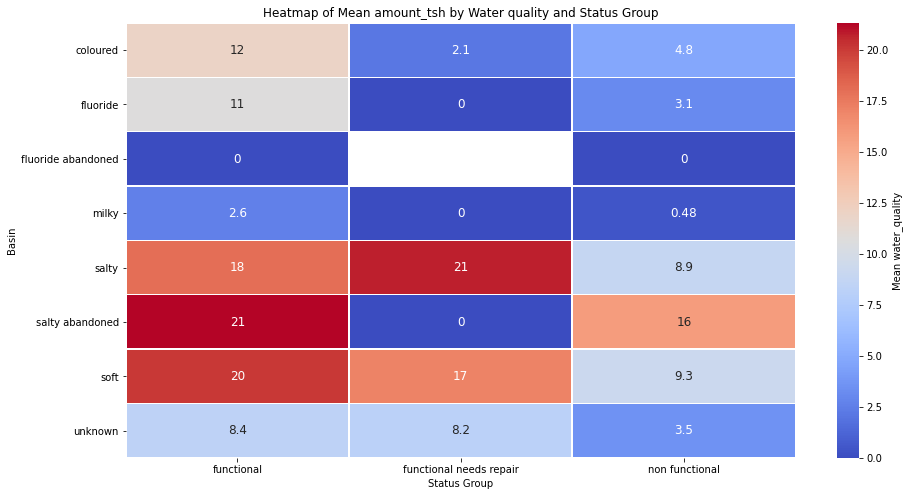

In [ ]:
# Create a pivot table with the mean amount_tsh for each combination of basin and status_group
pivot_table_mean = train_data_cleaned.pivot_table(index='water_quality', columns='status_group', values='amount_tsh', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table_mean, annot=True, cmap='coolwarm',annot_kws={"size": 12}, linewidths=0.5, cbar_kws={'label': 'Mean water_quality'})
plt.title('Heatmap of Mean amount_tsh by Water quality and Status Group')
plt.xlabel('Status Group')
plt.ylabel('Basin')
plt.show()



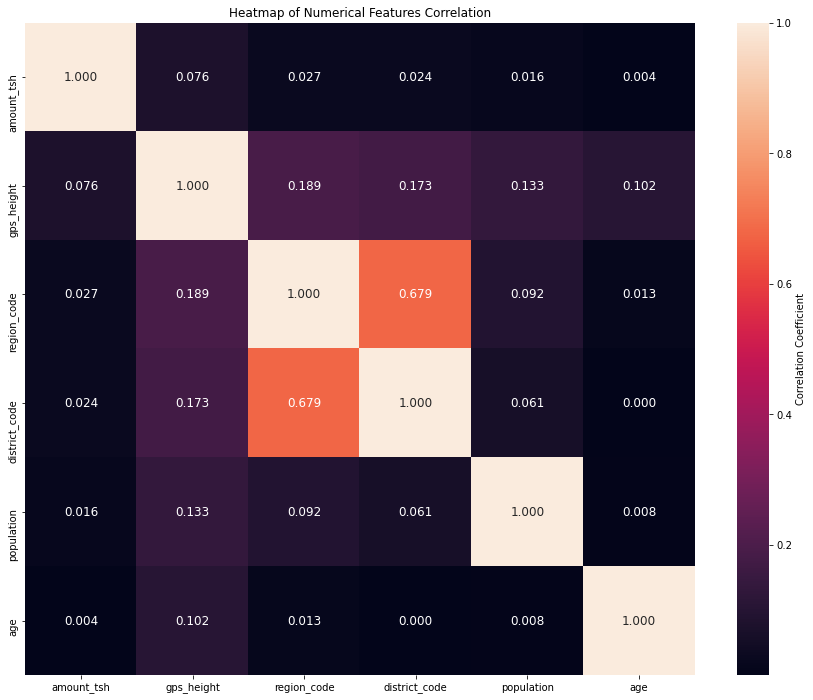

In [638]:
# Create a correlation matrix for numerical features
numerical_cols = train_data_cleaned.select_dtypes(include=[np.number]).columns
corr_matrix = train_data_cleaned[numerical_cols].corr().abs()

# Plot the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix,fmt=".3f", annot=True,annot_kws={"size": 12},cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Heatmap of Numerical Features Correlation')
plt.show()

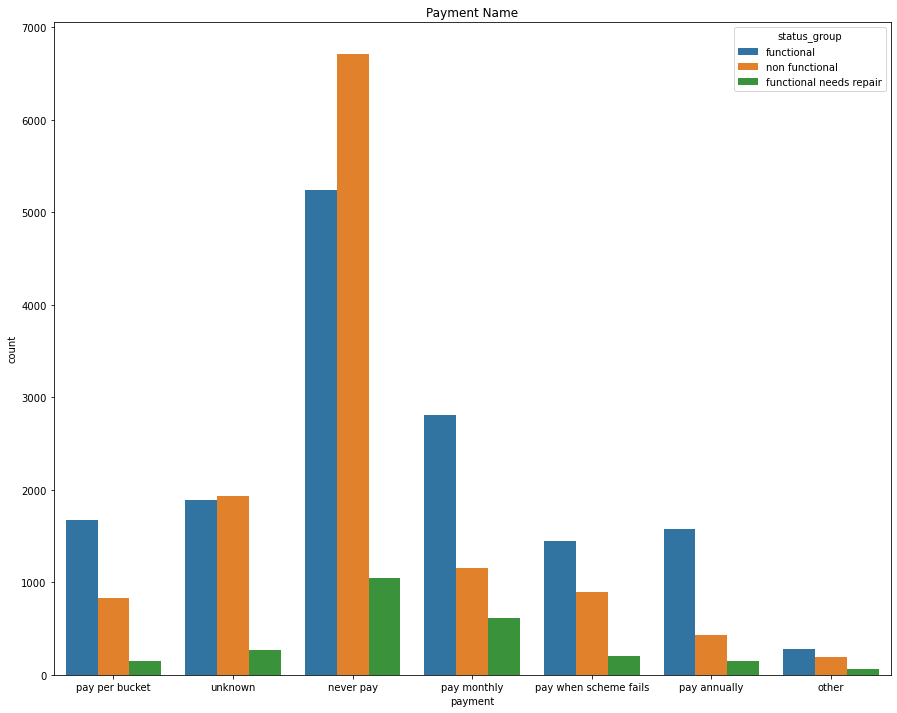

In [ ]:
plt.figure(figsize=(15,12))
ax = sns.countplot(x='payment', hue="status_group", data=df_installer)
plt.title('Payment Name')
plt.show()

Most non-fuctional water wells lie in the the never pay payment category. Same case for functional water wells.

In [ ]:
train_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59026 entries, 0 to 59025
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59026 non-null  float64
 1   gps_height             59026 non-null  float64
 2   basin                  59026 non-null  object 
 3   region_code            59026 non-null  float64
 4   district_code          59026 non-null  float64
 5   population             59026 non-null  float64
 6   public_meeting         59026 non-null  object 
 7   scheme_management      59026 non-null  object 
 8   permit                 59026 non-null  bool   
 9   extraction_type_class  59026 non-null  object 
 10  management             59026 non-null  object 
 11  payment                59026 non-null  object 
 12  water_quality          59026 non-null  object 
 13  quantity               59026 non-null  object 
 14  source                 59026 non-null  object 
 15  wa

## Modeling


#### Preprocessing

Splitting my data into X(independent features) and y(dependent feature)

In [639]:
# separate the features and target variable
X = train_data_cleaned.drop(columns = ['status_group'], axis = 1)
y = train_data_cleaned['status_group']

Splitting the dataset into training and testing sets

In [ ]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_cat = X_train.select_dtypes(exclude=["int64", "float64"]).copy()
X_train_cat.head(4)

,basin,public_meeting,scheme_management,permit,extraction_type_class,management,payment,water_quality,quantity,source,waterpoint_type,funder_cat,installer_cat
26453,Lake Victoria,True,WUG,False,handpump,wug,other,soft,enough,shallow well,hand pump,Others,DWE
49,Rufiji,True,VWC,True,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,District Council,DWE
47620,Lake Tanganyika,True,Water authority,True,gravity,water board,pay monthly,soft,enough,river,communal standpipe,Others,Others
56476,Rufiji,True,Unknown,True,handpump,vwc,never pay,soft,enough,shallow well,hand pump,Others,DWE


One-hot Encoding the categorical features

In [ ]:
# categorical features in the training set
categorical_features = ['funder_cat', 'installer_cat', 'basin', 'scheme_management', 'extraction_type_class',
                         'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']
X_train_cat = X_train[categorical_features].copy()
X_train_cat.head(4)

,funder_cat,installer_cat,basin,scheme_management,extraction_type_class,management,payment,water_quality,quantity,source,waterpoint_type
26453,Others,DWE,Lake Victoria,WUG,handpump,wug,other,soft,enough,shallow well,hand pump
49,District Council,DWE,Rufiji,VWC,gravity,vwc,pay annually,soft,enough,spring,communal standpipe
47620,Others,Others,Lake Tanganyika,Water authority,gravity,water board,pay monthly,soft,enough,river,communal standpipe
56476,Others,DWE,Rufiji,Unknown,handpump,vwc,never pay,soft,enough,shallow well,hand pump


In [ ]:
# one-hot encode the categorical features
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(X_train_cat)

X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_cat),
    index=X_train_cat.index,
    columns=np.hstack(ohe.categories_)
)
X_train_ohe

,Danida,District Council,Government Of Tanzania,Hesawa,Kkkt,Others,Rwssp,Tasaf,Unicef,World Bank,...,shallow well,spring,unknown,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other
26453,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
49,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47620,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
56476,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24650,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
38158,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
860,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15795,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Dealing with numeric values

In [ ]:
numeric_features = ['amount_tsh', 'gps_height', 'district_code', 'region_code', 'population', 'age']
X_train_num = X_train[numeric_features].copy()
X_train_num.head(5)

,amount_tsh,gps_height,district_code,region_code,population,age
26453,0.0,0.0,2.0,17.0,0.0,24.0
49,62.5,2169.0,4.0,11.0,20.0,17.0
47620,62.5,1065.0,2.0,16.0,380.0,24.0
56476,0.0,538.0,4.0,5.0,300.0,27.0
24650,0.0,0.0,8.0,17.0,0.0,24.0


Scaling numeric features using MinMaxScaler

In [ ]:
# using MinMaxScaler to scale the numeric features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_num)
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_num),
    # index is important to ensure we can concatenate with other columns
    index=X_train_num.index,
    columns=X_train_num.columns
)
X_train_scaled

,amount_tsh,gps_height,district_code,region_code,population,age
26453,0.0,0.031469,0.210526,0.470588,0.000000,0.412698
49,1.0,0.789860,0.421053,0.294118,0.036364,0.190476
47620,1.0,0.403846,0.210526,0.441176,0.690909,0.412698
56476,0.0,0.219580,0.421053,0.117647,0.545455,0.507937
24650,0.0,0.031469,0.842105,0.470588,0.000000,0.412698
...,...,...,...,...,...,...
54343,0.0,0.134615,0.315789,0.117647,1.000000,0.857143
38158,0.0,0.031469,0.631579,0.470588,0.000000,0.412698
860,0.0,0.031469,0.736842,0.529412,0.000000,0.412698
15795,0.0,0.052448,0.210526,0.147059,0.090909,0.444444


In [ ]:
# Concatenate the one-hot encoded features with the scaled features
X_train_full = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_train_full.head(3)

,amount_tsh,gps_height,district_code,region_code,population,age,Danida,District Council,Government Of Tanzania,Hesawa,...,shallow well,spring,unknown,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other
26453,0.0,0.031469,0.210526,0.470588,0.000000,0.412698,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
49,1.0,0.789860,0.421053,0.294118,0.036364,0.190476,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47620,1.0,0.403846,0.210526,0.441176,0.690909,0.412698,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Applying the same preprocessing to our test data so we can evaluate the model's performance on unseen data

In [ ]:
# Handling categorical data
X_test_cat = X_test[categorical_features].copy()
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test_cat),
    index=X_test_cat.index,
    columns=np.hstack(ohe.categories_)
)

# Normalization
X_test_num = X_test[numeric_features].copy()
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_num),
    index=X_test_num.index,
    columns=X_test_num.columns
)

# Concatenating categorical and numeric data
X_test_full = pd.concat([X_test_scaled, X_test_ohe], axis=1)
X_test_full.head(4)

,amount_tsh,gps_height,district_code,region_code,population,age,Danida,District Council,Government Of Tanzania,Hesawa,...,shallow well,spring,unknown,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other
52449,0.0,0.031469,0.421053,0.323529,0.000000,0.412698,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18863,0.0,0.586014,0.210526,0.588235,0.589091,0.253968,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
44390,0.0,0.501049,0.105263,0.117647,0.181818,0.190476,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50756,1.0,0.153147,0.421053,0.117647,0.909091,0.412698,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
print("X_train_full shape:", X_train_full.shape)
print("y_train shape:", y_train.shape)
print("X_test_full shape:", X_test_full.shape)
print("y_test shape:", y_test.shape)

X_train_full shape: (47220, 105)
y_train shape: (47220,)
X_test_full shape: (11806, 105)
y_test shape: (11806,)


### Model 1: Logistic Regression(Baseline Model)

Training Accuracy: 0.7347522236340533

Testing Accuracy: 0.7287819752668134
Testing F1 Score: 0.7015235221710937
Testing Classification Report:
                          precision    recall  f1-score   support

             functional       0.71      0.90      0.79      6345
functional needs repair       0.39      0.04      0.08       877
         non functional       0.78      0.63      0.70      4584

               accuracy                           0.73     11806
              macro avg       0.63      0.52      0.52     11806
           weighted avg       0.71      0.73      0.70     11806



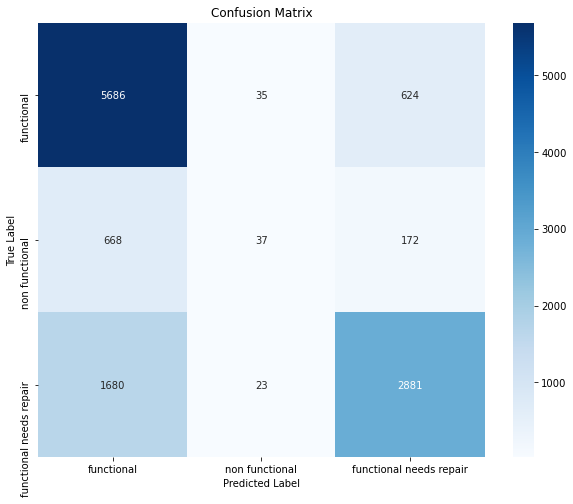

In [ ]:
# Instantiate logistic regression model
model = LogisticRegression(max_iter=1000)

# Instantiate Modelbuilder with your model
model_builder_log = Modelbuilder(model)

# Fit the model
model_builder_log.fit(X_train_full, y_train)

# Predict on the training set
y_train_pred = model_builder_log.predict_train(X_train_full)

# Predict on the test set
y_test_pred = model_builder_log.predict_test(X_test_full)

# Evaluate the model
evaluation_results = model_builder_log.evaluate(y_train, y_train_pred, y_test, y_test_pred)

# Print evaluation metrics for training set
train_accuracy = evaluation_results['train']['accuracy']
print("Training Accuracy:", train_accuracy)

# Print evaluation metrics for testing set
test_results = evaluation_results['test']
print("\nTesting Accuracy:", test_results['accuracy'])
print("Testing F1 Score:", test_results['f1_score'])
print("Testing Classification Report:\n", test_results['classification_report'])

# Get the unique class labels for testing set
target_names = pd.Series(y_test_pred).unique().tolist()

# Create a confusion matrix dataframe
cm_df = pd.DataFrame(test_results['confusion_matrix'], index=target_names, columns=target_names)

# Display confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Classifier was about 72.87% on our testing data with an F1=score of about 70%.

For the training set, it has an accuracy of about 73.46%

### Model 2: Decision Trees

Training Accuracy: 0.9433079203727234

Testing Accuracy: 0.7522446213789599
Testing F1 Score: 0.7500658899760168
Testing Classification Report:
                          precision    recall  f1-score   support

             functional       0.78      0.82      0.80      6345
functional needs repair       0.38      0.34      0.36       877
         non functional       0.78      0.74      0.76      4584

               accuracy                           0.75     11806
              macro avg       0.65      0.63      0.64     11806
           weighted avg       0.75      0.75      0.75     11806



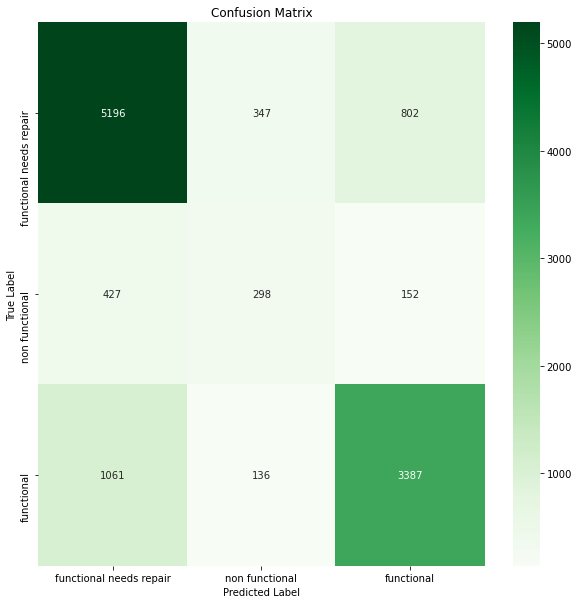

In [ ]:
# Instantiate decision tree model
model = DecisionTreeClassifier(random_state=10, criterion='entropy')

# Instantiate Modelbuilder with your model
model_builder = Modelbuilder(model)

# Fit the model
model_builder.fit(X_train_full, y_train)

# Predict on the training set
y_train_pred = model_builder.predict_train(X_train_full)

# Predict on the test set
y_test_pred = model_builder.predict_test(X_test_full)

# Evaluate the model
evaluation_results = model_builder.evaluate(y_train, y_train_pred, y_test, y_test_pred)

# Print evaluation metrics for training set
train_accuracy = evaluation_results['train']['accuracy']
print("Training Accuracy:", train_accuracy)

# Print evaluation metrics for testing set
test_results = evaluation_results['test']
print("\nTesting Accuracy:", test_results['accuracy'])
print("Testing F1 Score:", test_results['f1_score'])
print("Testing Classification Report:\n", test_results['classification_report'])

# Get the unique class labels for testing set
target_names = pd.Series(y_test_pred).unique().tolist()

# Create a confusion matrix dataframe
cm_df = pd.DataFrame(test_results['confusion_matrix'], index=target_names, columns=target_names)

# Display confusion matrix as heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


The model improves on the accuracy of both the training and testing data. The test data has an accuracy of 75% while the training data has an accuracy of 94%.



Retraining the decision tree model

In [ ]:
# Instantiate decision tree model
#retraining classifier with optimal values
model = DecisionTreeClassifier(criterion='entropy',
                           max_features=6,
                           max_depth=10,
                           min_samples_split=20,
                           min_samples_leaf=0.25, 
                           random_state=10)

# Instantiate Modelbuilder with your model
model_builder = Modelbuilder(model)

# Fit the model
model_builder.fit(X_train_full, y_train)

# Predict on the training set
y_train_pred = model_builder.predict_train(X_train_full)

# Predict on the test set
y_test_pred = model_builder.predict_test(X_test_full)

# Evaluate the model
evaluation_results = model_builder.evaluate(y_train, y_train_pred, y_test, y_test_pred)

# Print evaluation metrics for training set
train_accuracy = evaluation_results['train']['accuracy']
print("Training Accuracy:", train_accuracy)

# Print evaluation metrics for testing set
test_results = evaluation_results['test']
print("\nTesting Accuracy:", test_results['accuracy'])
print("Testing F1 Score:", test_results['f1_score'])
print("Testing Classification Report:\n", test_results['classification_report'])

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 0.5444515036001695

Testing Accuracy: 0.5374385905471794
Testing F1 Score: 0.37574214721192806
Testing Classification Report:
                          precision    recall  f1-score   support

             functional       0.54      1.00      0.70      6345
functional needs repair       0.00      0.00      0.00       877
         non functional       0.00      0.00      0.00      4584

               accuracy                           0.54     11806
              macro avg       0.18      0.33      0.23     11806
           weighted avg       0.29      0.54      0.38     11806



The model was worse that the previous model.

### Model 3: Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth= 5)

# Instantiate Modelbuilder with your model
model_builder = Modelbuilder(model)

# Fit the model
model_builder.fit(X_train_full, y_train)

# Predict on the training set
y_train_pred = model_builder.predict_train(X_train_full)

# Predict on the test set
y_test_pred = model_builder.predict_test(X_test_full)

# Evaluate the model
evaluation_results = model_builder.evaluate(y_train, y_train_pred, y_test, y_test_pred)

# Print evaluation metrics for training set
train_accuracy = evaluation_results['train']['accuracy']
print("Training Accuracy:", train_accuracy)

# Print evaluation metrics for testing set
test_results = evaluation_results['test']
print("\nTesting Accuracy:", test_results['accuracy'])
print("Testing F1 Score:", test_results['f1_score'])
print("Testing Classification Report:\n", test_results['classification_report'])


c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 0.7220669207962728

Testing Accuracy: 0.715907165847874
Testing F1 Score: 0.6746303055709281
Testing Classification Report:
                          precision    recall  f1-score   support

             functional       0.67      0.97      0.79      6345
functional needs repair       0.00      0.00      0.00       877
         non functional       0.89      0.51      0.65      4584

               accuracy                           0.72     11806
              macro avg       0.52      0.49      0.48     11806
           weighted avg       0.70      0.72      0.67     11806



The model has a training accuracy of 72% and a testing accuracy of 71.6%. 

The confusion matrix

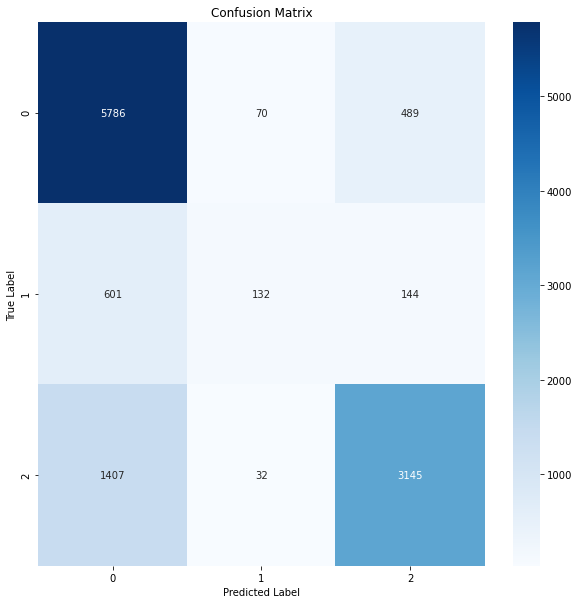

In [ ]:
# Get the confusion matrix from test_results
confusion_matrix = test_results['confusion_matrix']

# Display confusion matrix as heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Model 4: XGBoost

Duplicate Columns: Index(['Others', 'other', 'other', 'unknown', 'unknown', 'unknown', 'other',
       'unknown', 'dam', 'other'],
      dtype='object')
Training Accuracy: 0.7927361287590005

Testing Accuracy: 0.7676605116042691
Testing F1 Score: 0.7495827473443034
Testing Classification Report:
                          precision    recall  f1-score   support

             functional       0.74      0.91      0.82      6345
functional needs repair       0.56      0.15      0.24       877
         non functional       0.83      0.69      0.75      4584

               accuracy                           0.77     11806
              macro avg       0.71      0.58      0.60     11806
           weighted avg       0.76      0.77      0.75     11806



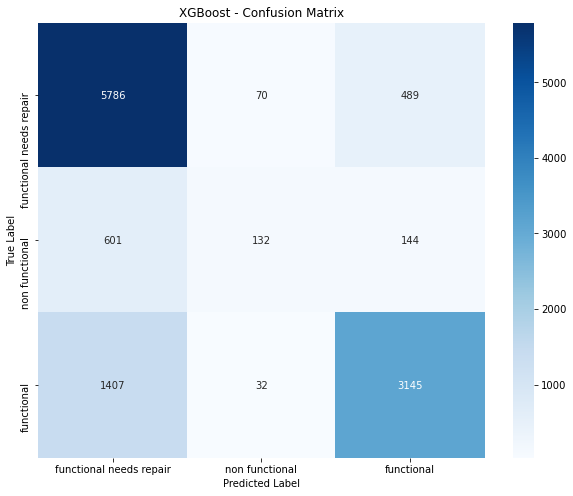

In [ ]:
# Check for duplicate column names
duplicate_columns = X_train_full.columns[X_train_full.columns.duplicated()]
print("Duplicate Columns:", duplicate_columns)

# Remove duplicate columns
X_train_full_unique = X_train_full.loc[:, ~X_train_full.columns.duplicated()]
X_test_full_unique = X_test_full.loc[:, ~X_test_full.columns.duplicated()]

# Instantiate XGBoost model
model = xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.8)

# Instantiate Modelbuilder with your model
model_builder_xgboost = Modelbuilder(model)

# Fit the model
model_builder_xgboost.fit(X_train_full_unique, y_train)

# Predict on the training set
y_train_pred = model_builder_xgboost.predict_train(X_train_full_unique)

# Predict on the test set
y_test_pred = model_builder_xgboost.predict_test(X_test_full_unique)

# Evaluate the model
evaluation_results = model_builder_xgboost.evaluate(y_train, y_train_pred, y_test, y_test_pred)

# Print evaluation metrics for training set
train_accuracy = evaluation_results['train']['accuracy']
print("Training Accuracy:", train_accuracy)

# Print evaluation metrics for testing set
test_results = evaluation_results['test']
print("\nTesting Accuracy:", test_results['accuracy'])
print("Testing F1 Score:", test_results['f1_score'])
print("Testing Classification Report:\n", test_results['classification_report'])

# Get the unique class labels for testing set
target_names = pd.Series(y_test_pred).unique().tolist()

# Create a confusion matrix dataframe
cm_df = pd.DataFrame(test_results['confusion_matrix'], index=target_names, columns=target_names)

# Display confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



The XGBoost Classifier was about 76.77% accurate on our testing data with an F1=score of about 74.96%.

Using Pipelines with RandomForestClassifier

In [ ]:
# Define the ensemble model pipeline
ensemble_pipeline = Pipeline([
    # Add any other preprocessing steps here if needed
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=5))  # Random Forest classifier
])

# Fit the ensemble model
ensemble_pipeline.fit(X_train_full, y_train)

# Predictions
y_train_pred = ensemble_pipeline.predict(X_train_full)
y_test_pred = ensemble_pipeline.predict(X_test_full)

# Evaluate the ensemble model
ensemble_accuracy_train = accuracy_score(y_train, y_train_pred)
ensemble_accuracy_test = accuracy_score(y_test, y_test_pred)

# Print evaluation metrics
print("Ensemble Model - Training Accuracy:", ensemble_accuracy_train)
print("Ensemble Model - Testing Accuracy:", ensemble_accuracy_test)

Ensemble Model - Training Accuracy: 0.7213680643795002
Ensemble Model - Testing Accuracy: 0.7153989496866


Lets modify the pipeline model

In [ ]:
# Define the base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=5))
]

# Define the meta-model
meta_model = RandomForestClassifier(n_estimators=100, max_depth=5)

# Create the stacking classifier
stacking_classifier = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5  # Cross-validation folds
)

# Create the pipeline
stacking_pipeline = make_pipeline(
    stacking_classifier
)

# Fit the stacking classifier
stacking_pipeline.fit(X_train_full, y_train)

# Predictions
y_train_pred = stacking_pipeline.predict(X_train_full)
y_test_pred = stacking_pipeline.predict(X_test_full)

# Evaluate the stacking classifier
stacking_accuracy_train = accuracy_score(y_train, y_train_pred)
stacking_accuracy_test = accuracy_score(y_test, y_test_pred)

# Print evaluation metrics
print("Stacking Classifier - Training Accuracy:", stacking_accuracy_train)
print("Stacking Classifier - Testing Accuracy:", stacking_accuracy_test)


Stacking Classifier - Training Accuracy: 0.7888182973316391
Stacking Classifier - Testing Accuracy: 0.7673217008300864


The stacked classifier has a testing accuracy of about 76% passing our success metric.

### Testing the models on the unseen data.

In [ ]:
# load the testing data
testing_data = pd.read_csv('data/test_data_clean.csv')
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             14850 non-null  float64
 1   funder                 14850 non-null  object 
 2   gps_height             14850 non-null  int64  
 3   installer              14850 non-null  object 
 4   basin                  14850 non-null  object 
 5   region_code            14850 non-null  int64  
 6   district_code          14850 non-null  int64  
 7   population             14850 non-null  int64  
 8   public_meeting         14850 non-null  object 
 9   scheme_management      14850 non-null  object 
 10  permit                 14850 non-null  bool   
 11  extraction_type_class  14850 non-null  object 
 12  management             14850 non-null  object 
 13  payment                14850 non-null  object 
 14  water_quality          14850 non-null  object 
 15  qu

Grouping the funders and installers to ensure they are the same as the training data

Funder column

In [ ]:
# To group values together

testing_data['funder_cat'] = testing_data['funder'] #creating new column

c_fund = ['Danida','Government Of Tanzania','Hesawa','Rwssp','World Bank','Kkkt', 'World Vision',
         'Unicef','Tasaf','District Council']

testing_data.loc[~testing_data["funder_cat"].isin(c_fund), "funder_cat"] = "Others"

# to obtain the no of unique values
testing_data['funder_cat'].nunique()

11

In [ ]:
testing_data.drop(columns=['funder'],inplace=True )

Installer column

In [ ]:
# To make new categorizes, creating new column
testing_data['installer_cat'] = testing_data['installer']
# to convert the values which have less than 400 value counts to "others"
c_ins = ['DWE','Government','Community','DANIDA','RWE','District council', 'Central government',
         'KKKT','HESAWA','TCRS']

testing_data.loc[~testing_data["installer_cat"].isin(c_ins), "installer_cat"] = "Others"
# Now that we have categorized installer column, we can proceed to drop it
testing_data.drop(columns=['installer'],inplace=True )

Preprocessing before deploying model

In [ ]:
# categorical features in the training set
categorical_features = ['funder_cat', 'installer_cat', 'basin', 'scheme_management', 'extraction_type_class',
                         'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']
testing_data_cat = testing_data[categorical_features].copy()
testing_data_cat.head(4)

,funder_cat,installer_cat,basin,scheme_management,extraction_type_class,management,payment,water_quality,quantity,source,waterpoint_type
0,Others,Others,Internal,Parastatal,other,parastatal,never pay,soft,seasonal,rainwater harvesting,other
1,Government Of Tanzania,DWE,Pangani,VWC,gravity,vwc,never pay,soft,insufficient,spring,communal standpipe
2,Others,Others,Internal,VWC,other,vwc,never pay,soft,insufficient,rainwater harvesting,other
3,Others,Others,Ruvuma / Southern Coast,VWC,other,vwc,unknown,soft,dry,shallow well,other


In [ ]:
# one-hot encode the categorical features
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(testing_data_cat)

testing_data_ohe = pd.DataFrame(
    ohe.transform(testing_data_cat),
    index=testing_data_cat.index,
    columns=np.hstack(ohe.categories_)
)
testing_data_ohe

,Danida,District Council,Government Of Tanzania,Hesawa,Kkkt,Others,Rwssp,Tasaf,Unicef,World Bank,...,shallow well,spring,unknown,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14846,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14847,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14848,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
numeric_features = ['amount_tsh', 'gps_height', 'district_code', 'region_code', 'population', 'age']
testing_data_num = testing_data[numeric_features].copy()
testing_data_num.head(5)

,amount_tsh,gps_height,district_code,region_code,population,age
0,0.0,1996,3,21,321,12
1,0.0,1569,2,2,300,24
2,0.0,1567,2,13,500,14
3,0.0,267,43,80,250,37
4,500.0,1260,3,10,60,24


In [ ]:
# using MinMaxScaler to scale the numeric features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(testing_data_num)
testing_data_scaled = pd.DataFrame(
    scaler.transform(testing_data_num),
    # index is important to ensure we can concatenate with other columns
    index=testing_data_num.index,
    columns=testing_data_num.columns
)
testing_data_scaled

,amount_tsh,gps_height,district_code,region_code,population,age
0,0.0000,0.724418,0.0375,0.204082,0.027988,0.018868
1,0.0000,0.573747,0.0250,0.010204,0.026157,0.245283
2,0.0000,0.573042,0.0250,0.122449,0.043596,0.056604
3,0.0000,0.114326,0.5375,0.806122,0.021798,0.490566
4,0.0025,0.464714,0.0375,0.091837,0.005231,0.245283
...,...,...,...,...,...,...
14845,0.0000,0.032110,0.0125,0.051020,0.001744,0.471698
14846,0.0050,0.020113,0.0875,0.030612,0.258087,0.358491
14847,0.0000,0.540932,0.0250,0.122449,0.017438,0.056604
14848,0.0000,0.372265,0.0250,0.091837,0.013079,0.075472


In [ ]:
# Concatenate the one-hot encoded features with the scaled features
testing_data_full = pd.concat([testing_data_scaled, testing_data_ohe], axis=1)
testing_data_full.head(3)

,amount_tsh,gps_height,district_code,region_code,population,age,Danida,District Council,Government Of Tanzania,Hesawa,...,shallow well,spring,unknown,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other
0,0.0,0.724418,0.0375,0.204082,0.027988,0.018868,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.573747,0.0250,0.010204,0.026157,0.245283,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.573042,0.0250,0.122449,0.043596,0.056604,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Test 1 : Using our baseline model(Logistic Regression)

In [ ]:
# Fit the logistic regression model
model_builder_log.fit(X_train_full, y_train)

# Predict on the unseen data using the trained model
y_unseen_pred = model_builder_log.model.predict(testing_data_full)

# Print the predicted labels for the unseen data
print("Predicted Labels for Unseen Data:\n", y_unseen_pred)

Predicted Labels for Unseen Data:
 ['non functional' 'functional' 'non functional' ... 'functional'
 'functional' 'non functional']


In [ ]:
# Create a copy of the unseen data DataFrame
unseen_data_with_predictions = testing_data_full.copy()

# Add a new column to store the predicted labels
unseen_data_with_predictions['predicted_status'] = y_unseen_pred

# Print the combined DataFrame
unseen_data_with_predictions.head(5)

,amount_tsh,gps_height,district_code,region_code,population,age,Danida,District Council,Government Of Tanzania,Hesawa,...,spring,unknown,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other,predicted_status
0,0.0000,0.724418,0.0375,0.204082,0.027988,0.018868,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,non functional
1,0.0000,0.573747,0.0250,0.010204,0.026157,0.245283,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,functional
2,0.0000,0.573042,0.0250,0.122449,0.043596,0.056604,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,non functional
3,0.0000,0.114326,0.5375,0.806122,0.021798,0.490566,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,non functional
4,0.0025,0.464714,0.0375,0.091837,0.005231,0.245283,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,functional


Test 2: XGBoost model

In [ ]:
# Fit the model
model_builder_xgboost.fit(X_train_full_unique, y_train)

# Check for duplicate column names in the unseen data
duplicate_columns_unseen = testing_data_full.columns[testing_data_full.columns.duplicated()]
print("Duplicate Columns in Unseen Data:", duplicate_columns_unseen)

# Remove duplicate columns from the unseen data
testing_data_full_unique = testing_data_full.loc[:, ~testing_data_full.columns.duplicated()]

# Predict on the unseen data using the trained XGBoost model
y_unseen_pred_xgb = model_builder_xgboost.model.predict(testing_data_full_unique)

# Print the predicted labels for the unseen data
print("Predicted Labels for Unseen Data:\n", y_unseen_pred_xgb)

Duplicate Columns in Unseen Data: Index(['Others', 'other', 'other', 'unknown', 'unknown', 'unknown', 'other',
       'unknown', 'dam', 'other'],
      dtype='object')
Predicted Labels for Unseen Data:
 ['non functional' 'non functional' 'functional' ... 'functional'
 'functional' 'non functional']


In [ ]:
# Create a copy of the unseen data DataFrame
unseen_data_with_predictions_xgb = testing_data_full.copy()

# Add a new column to store the predicted labels
unseen_data_with_predictions_xgb['predicted_status'] = y_unseen_pred_xgb

# Print the combined DataFrame
unseen_data_with_predictions_xgb.head(5)

,amount_tsh,gps_height,district_code,region_code,population,age,Danida,District Council,Government Of Tanzania,Hesawa,...,spring,unknown,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other,predicted_status
0,0.0000,0.724418,0.0375,0.204082,0.027988,0.018868,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,non functional
1,0.0000,0.573747,0.0250,0.010204,0.026157,0.245283,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,non functional
2,0.0000,0.573042,0.0250,0.122449,0.043596,0.056604,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,functional
3,0.0000,0.114326,0.5375,0.806122,0.021798,0.490566,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,non functional
4,0.0025,0.464714,0.0375,0.091837,0.005231,0.245283,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,functional


### Conclusion

I was able to create models for my data.The models include random forest, decision trees, XGboost. I was also able to integrate the concept of pipelines and stacking in my project. 

In addition i was able to test my model on unseen data. 

Based on my success metric, i settled on XGBoost classifier as my model.

### Recommendation

From the study I have done, I would recommend using XGBoost model to make predictions on Tanzanian water wells. The model had a testing accuracy of about 76%. This will allow the the government and other stakeholders like the NGO's to optimize their resource allocation by sending maintenance teams to pumps that truly need repairs or are non-functional. 

This will help ensure continuity of these water wells running. It wil also help them in coming up with better methods to build water wells that can last for long.

### Limitations

Some limitations that I ran into include:

1. Class Imbalance: there are very few data points with Function Needs Repair.
2. Time to run models: running multiple GridSearchCV fits can take hours if not days.
3. Lack of domain expertise: I am not well versed in what factors for water pumps contribute to its ability to function or not

### Next Steps

1. Improve class imbalance by using techniques such as oversampling or undersampling to balance the class distribution in the training data. 
2. Use Hyperparameter tuning. Using Grid search or random search can help improve the model's ability to generalize and make accurate predictions on unseen data.
3. Incorporating Cross-validation. This will help identify whether the model's performance is consistent across different subsets of the data and reduce the risk of overfitting.
4. Gain a deeper understanding of the domain and the factors that influence the functionality of waterpoints.